In [74]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error




In [124]:
ps = range(0, 1)
d = range(0, 2)
qs = range(0, 12)
# 季节项相关的参数
Ps = range(0, 1)
D = range(1, 2)
Qs = range(1, 2)
# 将参数打包，传入下面的数据，是哦那个BIC准则进行参数选择
params_list = list(product(ps, d, qs, Ps, D, Qs))

def find_best_params(data,params_list):
    
    result = []
    best_bic = 100000
    for param in tqdm_notebook(params_list):
        # 模型拟合
        # model = SARIMAX(data,order=(param[0], param[1], param[2]),seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        model = SARIMAX(data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        bicc = model.bic # 拟合出模型的BIC值
        # print(bic)
        # 寻找最优的参数
        if bicc < best_bic:
            best_mode = model
            best_bic = bicc
            best_param = param
        param_1 = (param[0], param[1], param[2])
        param_2 = (param[3], param[4], param[5], 12)
        param = 'SARIMA{0}x{1}'.format(param_1, param_2)
        # print(param)
        result.append([param, model.bic])
    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters', 'bic']
    result_table = result_table.sort_values(by='bic',ascending=True).reset_index(drop=True)
    return result_table

file_path = './source_data/A1backup.xlsx'
data = pd.read_excel(file_path)
data = data[['月份','销量（箱）']]
data.columns = ['date','y']
data['date'] = pd.to_datetime(data['date'].astype(str),format='%Y%m')
data.set_index('date', inplace=True)
# data = data[:100]
data
# result_table = find_best_params(data[:100], params_list)
# print(result_table)

,y
date,
2011-01-01,265.836
2011-02-01,72.268
2011-03-01,96.396
2011-04-01,76.400
2011-05-01,101.368
...,...
2022-03-01,NaN
2022-04-01,NaN
2022-05-01,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -431.728
Date:                            Sat, 27 Jul 2024   AIC                            869.456
Time:                                    11:28:57   BIC                            876.853
Sample:                                01-01-2011   HQIC                           872.434
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8589      0.073    -11.796      0.000      -1.002      -0.716
ma.S.L12      -0.4160      0.067     -6.225      0.000      -0.547      -0.285
sigma2      1145.8269     93.553     12.248      0.000     962.466    1329.187
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):               183.98
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -1.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

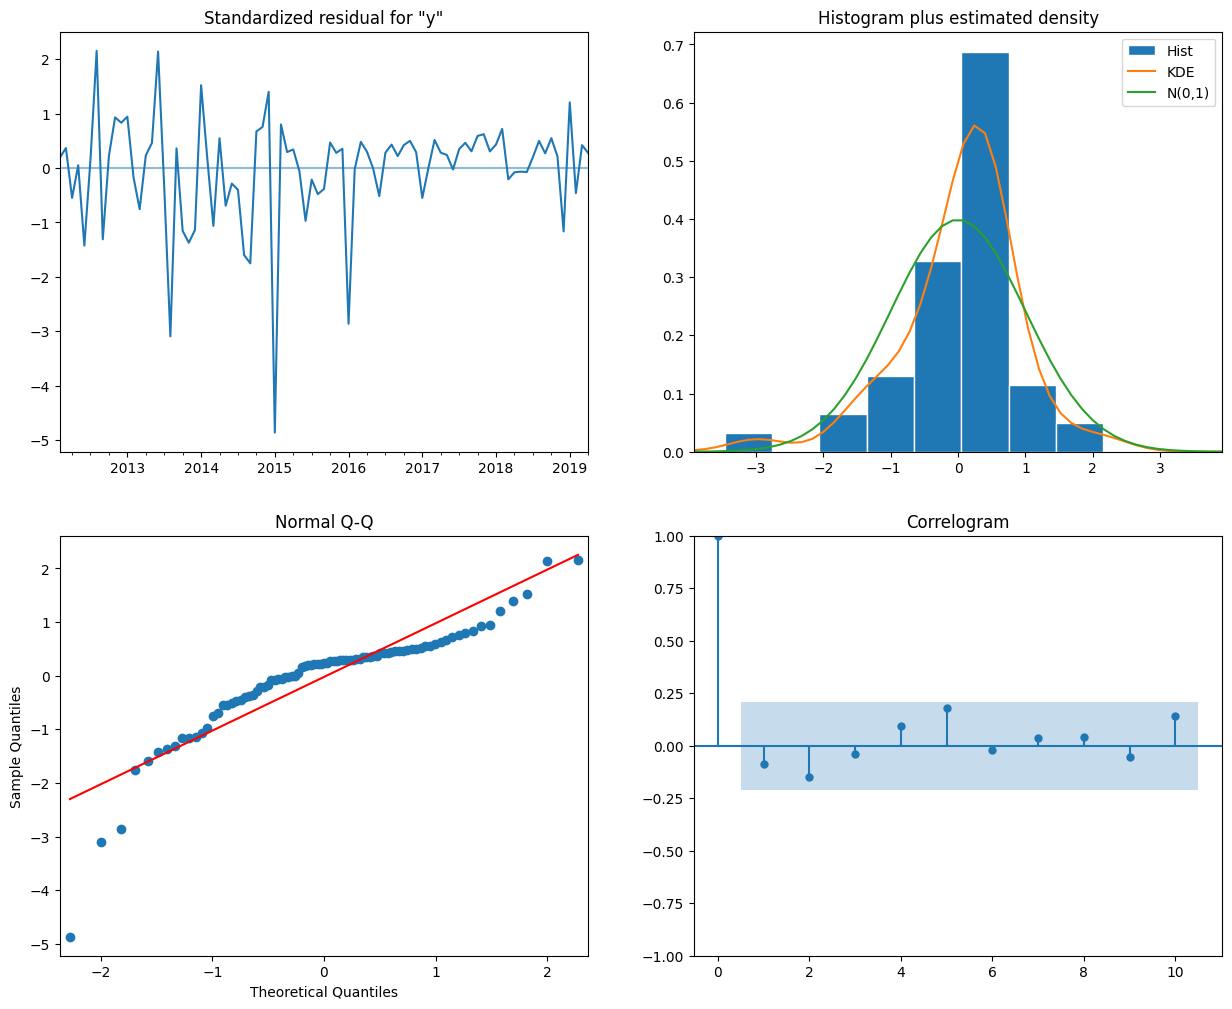

In [76]:
bst_model = SARIMAX(data[:100],order=(0, 1, 1),seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
resid = bst_model.resid
fig = bst_model.plot_diagnostics(figsize=(15, 12))
bst_model.summary()

1610.377096803367

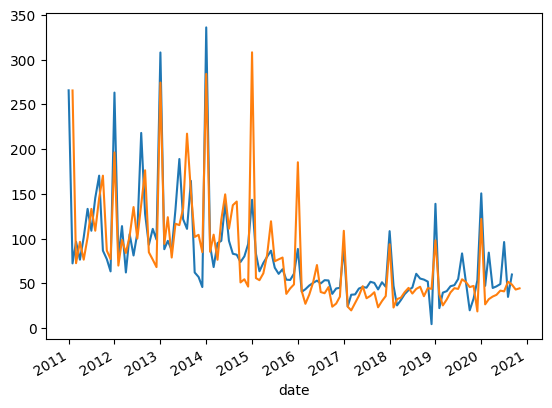

In [77]:

data_predict = bst_model.predict(1, 118)
data['y'].plot()
data_predict.plot()
data[100:117]
r2_score(data[100:117],data_predict[100:117])
mean_squared_error(data[100:117],data_predict[100:117])


In [151]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler


file_path = './source_data/A1.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data = raw_data[raw_data['sales']>=0]
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
data = raw_data[['date','sales']]
data.set_index('date', inplace=True)

def difference(data_set,interval=1):
    diff=list([0])
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled

diff_values = difference(data['sales'].values,1)
diff_values = pd.DataFrame(diff_values)
diff_values.index = data.index


train_num = 100
scaler,train_scaled,test_scaled=scale(diff_values[:train_num],diff_values[train_num:])
train_data = pd.DataFrame(train_scaled)
train_data.index = data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_scaled)
test_data.index = data.index[train_num:]
test_data.columns =['y']


ps = range(0, 1)
d = range(0, 2)
qs = range(0, 12)
# 季节项相关的参数
Ps = range(0, 1)
D = range(1, 2)
Qs = range(1, 2)
# 将参数打包，传入下面的数据，是哦那个BIC准则进行参数选择
params_list = list(product(ps, d, qs, Ps, D, Qs))

def find_best_params(data,params_list):
    
    result = []
    best_bic = 100000
    best_model = None
    for param in tqdm_notebook(params_list):
        # 模型拟合
        model = SARIMAX(data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        bicc = model.bic # 拟合出模型的BIC值
        print(bicc)
        # 寻找最优的参数
        if bicc < best_bic:
            
            best_model = model
            best_bic = bicc
            best_param = param
        param_1 = (param[0], param[1], param[2])
        param_2 = (param[3], param[4], param[5], 12)
        param = 'SARIMA{0}x{1}'.format(param_1, param_2)
        # print(param)
        result.append([param, model.bic])
    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters', 'bic']
    result_table = result_table.sort_values(by='bic',ascending=True).reset_index(drop=True)
    print(result_table)
    return best_model


best_model = find_best_params(train_data, params_list)
print(best_model)


  0%|          | 0/24 [00:00<?, ?it/s]

-35.5041219912587
-72.92930640572794
-68.45584922928069
-67.22045732519597
-63.15921993022948
-58.692647430236505
-54.51227501991683
-50.333469729767586
-45.8576038015311
-38.814603101764476
-37.23572526630733
-36.627906060892286
47.387028972936136
-23.963372439304592
-56.97326220990734
-52.19332653114217
-51.75679185268595
-47.91985011172741
-43.445255170282095
-38.691989721366966
-33.914587225218
-30.357168123266995
-24.911927703382098
-14.265972390450962
                        parameters        bic
0    SARIMA(0, 0, 1)x(0, 1, 1, 12) -72.929306
1    SARIMA(0, 0, 2)x(0, 1, 1, 12) -68.455849
2    SARIMA(0, 0, 3)x(0, 1, 1, 12) -67.220457
3    SARIMA(0, 0, 4)x(0, 1, 1, 12) -63.159220
4    SARIMA(0, 0, 5)x(0, 1, 1, 12) -58.692647
5    SARIMA(0, 1, 2)x(0, 1, 1, 12) -56.973262
6    SARIMA(0, 0, 6)x(0, 1, 1, 12) -54.512275
7    SARIMA(0, 1, 3)x(0, 1, 1, 12) -52.193327
8    SARIMA(0, 1, 4)x(0, 1, 1, 12) -51.756792
9    SARIMA(0, 0, 7)x(0, 1, 1, 12) -50.333470
10   SARIMA(0, 1, 5)x(0, 1, 1, 1

-72.92930640572794


902.2715388453844

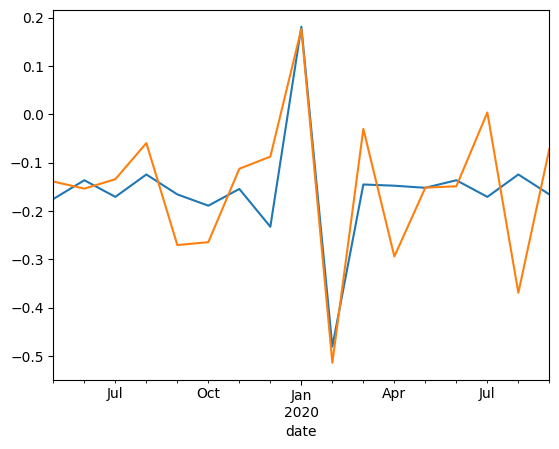

In [162]:

print(best_model.bic)
# data_predict = best_model.predict(1, 118)
# data_predict.plot()
# train_data['y'].plot()
predict_test = best_model.predict(train_num,train_num+16)
predict_test.plot()
test_data['y'].plot()
test_data_diff = scaler.inverse_transform(test_data)
predict_test_diff = scaler.inverse_transform(pd.DataFrame(predict_test))
r2_score(test_data_diff,predict_test_diff)
mean_squared_error(test_data_diff,predict_test_diff)


/Users/baigeiguai/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


-0.017287755176054853
10658.586274168149


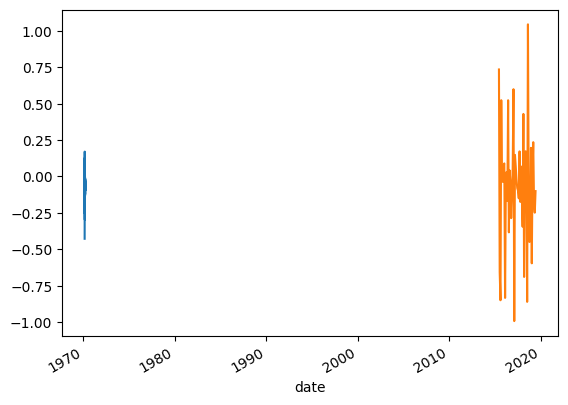

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A2.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data = raw_data[raw_data['sales']>=0]
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
data = raw_data[['date','sales']]
data.set_index('date', inplace=True)

def difference(data_set,interval=1):
    diff=list([0])
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled

diff_values = difference(data['sales'].values,1)
diff_values = pd.DataFrame(diff_values)
diff_values.index = data.index


train_num = 50
scaler,train_scaled,test_scaled=scale(diff_values[:train_num],diff_values[train_num:])
train_data = pd.DataFrame(train_scaled)
train_data.index = data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_scaled)
test_data.index = data.index[train_num:]
test_data.columns =['y']

model = auto_arima(train_data, seasonal=True, m=12)
test_predict = model.predict(test_data.shape[0])
test_predict.plot()
test_data['y'].plot()

test_data_diff = scaler.inverse_transform(test_data)
predict_test_diff = scaler.inverse_transform(pd.DataFrame(test_predict))
print(r2_score(test_data_diff,predict_test_diff))
print(mean_squared_error(test_data_diff,predict_test_diff))


-0.6049613862464123
1359.1025493206625


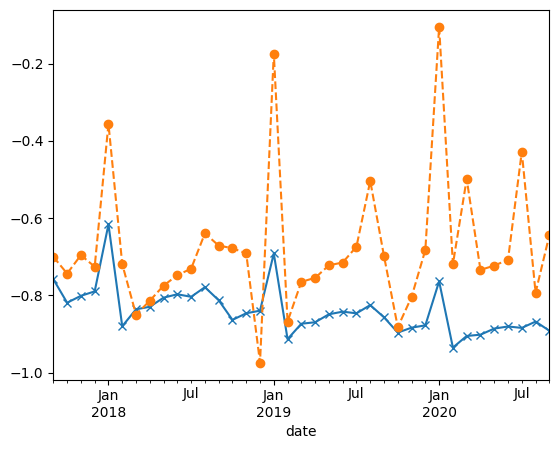

In [14]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A1.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data = raw_data[raw_data['sales']>=0]
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
data = raw_data[['date','sales']]

data.set_index('date', inplace=True)

def difference(data_set,interval=1):
    diff=list([0])
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled


# diff_values = difference(data['sales'].values,1)
# diff_values = pd.DataFrame(diff_values)
# diff_values.index = data.index


# train_num = 80
# scaler,train_scaled,test_scaled=scale(data[:train_num],data[train_num:])
# train_data = pd.DataFrame(train_scaled)
# train_data.index = data.index[:train_num]
# train_data.columns =['y']
# test_data = pd.DataFrame(test_scaled)
# test_data.index = data.index[train_num:]
# test_data.columns =['y']

# model = auto_arima(train_data, seasonal=True, m=12)
# test_predict = model.predict(test_data.shape[0])

# test_predict.index = test_data.index
# test_predict.plot(marker='x')
# test_data['y'].plot(linestyle='--',marker='o')

# test_data_diff = scaler.inverse_transform(test_data)
# predict_test_diff = scaler.inverse_transform(pd.DataFrame(test_predict))
# print(r2_score(test_data_diff,predict_test_diff))
# print(mean_squared_error(test_data_diff,predict_test_diff))


0.6374316419393228
282.4549441504505


<AxesSubplot:>

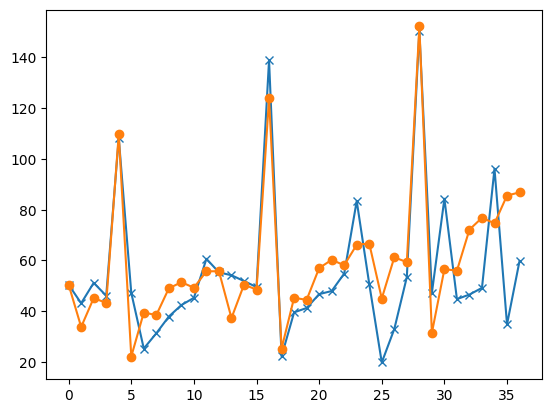

In [16]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A1backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data = raw_data[raw_data['sales']>=0]
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)


def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]


train_num = 80
train_data,test_data = diff_data[:train_num],diff_data[train_num:]

train_data = pd.DataFrame(train_data)
train_data.index = diff_data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_data)
test_data.index = data.index[train_num:-1]
test_data.columns =['y']


model = auto_arima(train_data[44:], seasonal=True, m=12)
test_predict = model.predict(test_data.shape[0])


test_predict.index = test_data.index



# test_predict.plot(marker='x')
# test_data['y'].plot(linestyle='--',marker='o')


def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict)
inverse_predict = inverse_predict.apply(np.expm1)
inverse_predict

inverse_test = inverse_difference(train_data.y.sum()+data['sales'][0],test_data['y'])
inverse_test = inverse_test.apply(np.expm1)

print(r2_score(inverse_test[0],inverse_predict[0]))
print(mean_squared_error(inverse_test[0],inverse_predict[0]))

inverse_test[0].plot(marker='x')
inverse_predict[0].plot(marker='o')
# plt.plot(range(len(inverse_predict)),inverse_predict[0],marker='x')
# plt.plot(range(len(inverse_test)),inverse_test[0],marker='o')
